In [68]:
! pip install pandas
import numpy as np
import pandas as pd
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

In [69]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,82.458740,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.001442,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,84.439507,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,84.544258,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,83.925270,7296900


<AxesSubplot:title={'center':'Star Bucks Stock Close Price'}, xlabel='Date'>

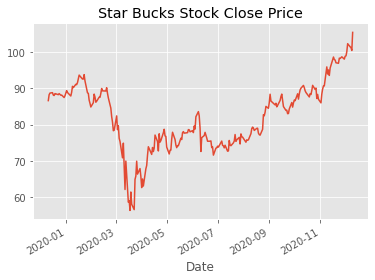

In [70]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df['Close'].plot(label='CLOSE', title='Star Bucks Stock Close Price')

In [71]:
close_price_df = df.iloc[:, 3:4]
close_price_df

,Close
Date,
2019-12-11,86.589996
2019-12-12,88.209999
2019-12-13,88.669998
2019-12-16,88.779999
2019-12-17,88.129997
...,...
2020-12-04,102.279999
2020-12-07,101.410004
2020-12-08,101.209999


In [72]:
! pip install sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()


c_price_mm = mm.fit_transform(close_price_df) 

In [73]:

train_set = c_price_mm[:200, :]
test_set = c_price_mm[200:, :] 

In [74]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

train_tensors = Variable(torch.Tensor(train_set))
test_tensors = Variable(torch.Tensor(test_set)) 


train_tensors_final = torch.reshape(train_tensors,  (train_tensors.shape[0], 1, train_tensors.shape[1])) 
test_tensors_final = torch.reshape(test_tensors,  (test_tensors.shape[0], 1, test_tensors.shape[1])) 

print("Training set shape", train_tensors_final.shape) 
print("Test set shape",  test_tensors_final.shape)

Training set shape torch.Size([200, 1, 1])
Test set shape torch.Size([53, 1, 1])


In [75]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

In [76]:
# define parameters and NN model
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, train_tensors_final.shape[1]) 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 


In [77]:
# train
for epoch in range(num_epochs):
  outputs = lstm1.forward(train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.21868
Epoch: 100, loss: 0.02196
Epoch: 200, loss: 0.00870
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000


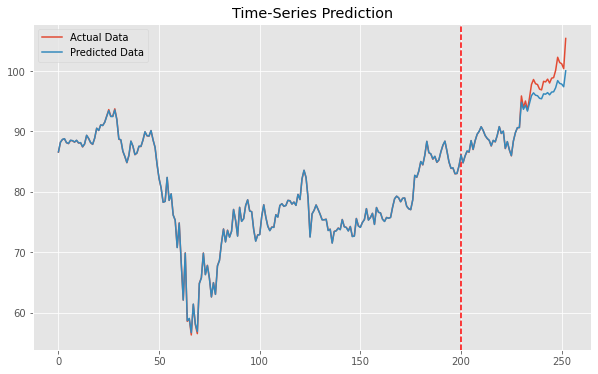

In [78]:
# Test on whole data set and plot results

whole_set = mm.transform(df.iloc[:, 3:4]) #old transformers


whole_set_tensor = Variable(torch.Tensor(whole_set))
#reshaping the dataset
whole_set_reshaped = torch.reshape(whole_set_tensor, (whole_set_tensor.shape[0], 1, whole_set_tensor.shape[1])) 


output = lstm1(whole_set_reshaped)#forward pass
data_predict = output.data.numpy() #numpy conversion
dataY_plot = whole_set_tensor.data.numpy()

predicted_data_tr = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(predicted_data_tr, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [55]:
whole_set_reshaped


tensor([[[0.6168]],

        [[0.6498]],

        [[0.6592]],

        [[0.6614]],

        [[0.6482]],

        [[0.6453]],

        [[0.6561]],

        [[0.6549]],

        [[0.6502]],

        [[0.6561]],

        [[0.6472]],

        [[0.6482]],

        [[0.6341]],

        [[0.6439]],

        [[0.6731]],

        [[0.6625]],

        [[0.6482]],

        [[0.6427]],

        [[0.6635]],

        [[0.6971]],

        [[0.6896]],

        [[0.7083]],

        [[0.7065]],

        [[0.7177]],

        [[0.7389]],

        [[0.7601]],

        [[0.7379]],

        [[0.7379]],

        [[0.7627]],

        [[0.7277]],

        [[0.6604]],

        [[0.6578]],

        [[0.6194]],

        [[0.6015]],

        [[0.5809]],

        [[0.6050]],

        [[0.6533]],

        [[0.6366]],

        [[0.6078]],

        [[0.6133]],

        [[0.6360]],

        [[0.6355]],

        [[0.6572]],

        [[0.6849]],

        [[0.6716]],

        [[0.6706]],

        [[0.6892]],

        [[0.6

In [53]:

dataY_plot[201:206]


array([[84.8 ],
       [85.92],
       [86.74],
       [86.57],
       [88.47]], dtype=float32)

In [54]:
predicted_data_tr[201:206]

array([[84.81551 ],
       [85.93718 ],
       [86.75748 ],
       [86.587494],
       [88.48489 ]], dtype=float32)